# Imports

In [60]:
import geopandas as gpd
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning, ConvergenceWarning
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize': (15, 10)})
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



# Data Processing

In [61]:
# read in the data
gdf = gpd.read_file("coral.geojson")

# get head of data
gdf.head()

,id,obs_id,date,first_name,last_name,region,location,color,shape,species,bleach_pct,depth_ft,h2o_temp_f,comment,photo_url,submit_lat,submit_lon,size_bytes,md5,geometry
0,hi_himb_all_coralcard.243,175,2019-10-15 09:42:00,Darrell,Kuamo'o,Hawaii,Richardson Ocean Center,4,mound,Porites lobata,None,3.0,NaN,"EHAP transect line, coral #1",None,19.737334,-155.013803,None,None,POINT (-155.01380 19.73733)
1,hi_himb_all_coralcard.250,182,2019-10-15 09:42:00,Darrell,Kuamo'o,Hawaii,Richardson Ocean Center,4,mound,Porites lobata,None,3.0,NaN,"EHAP transect line, coral #8",None,19.737334,-155.013803,None,None,POINT (-155.01380 19.73733)
2,hi_himb_all_coralcard.257,189,2019-10-15 09:52:00,Darrell,Kuamo'o,Hawaii,Richardson Ocean Center,22,branch,Pocillopora meandrina,None,3.0,NaN,"EHAP transect line 4, coral #5",None,19.737325,-155.013812,None,None,POINT (-155.01381 19.73732)
3,hi_himb_all_coralcard.263,195,2019-10-08 11:50:00,Anke,Roberts,Oahu,Hanauma Bay,19,crust,None,0-10%,5.0,NaN,None,None,21.270820,-157.696189,None,None,POINT (-157.69619 21.27082)
4,hi_himb_all_coralcard.270,202,2019-10-08 11:50:00,Anke,Roberts,Oahu,Hanauma Bay,7,crust,None,0-10%,4.0,NaN,None,None,21.270843,-157.696272,None,None,POINT (-157.69627 21.27084)


In [62]:
# describe the data
gdf.describe()

,obs_id,color,depth_ft,h2o_temp_f,submit_lat,submit_lon
count,50.000000,50.000000,49.000000,12.0,50.000000,50.000000
mean,100.000000,17.980000,33.734694,76.0,21.095152,-157.458601
std,100.582994,8.190313,23.396737,0.0,0.507124,0.927283
min,3.000000,0.000000,3.000000,76.0,19.737325,-157.863350
25%,22.500000,12.000000,4.000000,76.0,21.271283,-157.863350
50%,47.000000,19.000000,45.000000,76.0,21.288420,-157.862940
75%,193.750000,22.000000,55.000000,76.0,21.289667,-157.696133
max,451.000000,32.000000,55.000000,76.0,21.289667,-155.013803


In [63]:
# drop columns that are not needed
gdf = gdf.drop(columns=['id', 'geometry', 'date', 'first_name', 'last_name', 'species', 'h2o_temp_f',
                        'comment', 'photo_url', 'submit_lat', 'submit_lon', 'size_bytes', 'md5', 'obs_id'])


In [64]:
# display the data
gdf.head()

,region,location,color,shape,bleach_pct,depth_ft
0,Hawaii,Richardson Ocean Center,4,mound,None,3.0
1,Hawaii,Richardson Ocean Center,4,mound,None,3.0
2,Hawaii,Richardson Ocean Center,22,branch,None,3.0
3,Oahu,Hanauma Bay,19,crust,0-10%,5.0
4,Oahu,Hanauma Bay,7,crust,0-10%,4.0


In [65]:
# check the frequency of null values in each column as percent of column that has missing values
gdf.isnull().mean() * 100

region         0.0
location       2.0
color          0.0
shape          0.0
bleach_pct    14.0
depth_ft       2.0
dtype: float64

In [66]:
# check frequency of missing values on a row by row basis
gdf.isnull().sum(axis=1).sort_values(ascending=False)

38    3
41    1
39    1
40    1
0     1
1     1
2     1
35    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
46    0
45    0
37    0
26    0
48    0
47    0
42    0
43    0
44    0
36    0
25    0
24    0
12    0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
13    0
23    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
49    0
dtype: int64

In [67]:
# drop rows where bleach_pct is missing
gdf = gdf.dropna(subset=['bleach_pct']).reset_index(drop=True)

# drop region column
gdf = gdf.drop(columns=['region'])

In [68]:
# display the data
gdf.head()

,location,color,shape,bleach_pct,depth_ft
0,Hanauma Bay,19,crust,0-10%,5.0
1,Hanauma Bay,7,crust,0-10%,4.0
2,Hanauma Bay,19,branch,0-10%,4.0
3,Horseshoe Reef,22,mound,25-50%,45.0
4,Horseshoe Reef,15,mound,25-50%,45.0


In [69]:
# check values in bleack_pct column
gdf['bleach_pct'].value_counts(dropna=False)

0-10%     31
25-50%    12
Name: bleach_pct, dtype: int64

In [70]:
# set categorical variable
cat_type = CategoricalDtype(categories=['0-10%', '25-50%'], ordered=True)
gdf["bleach_pct"] = gdf["bleach_pct"].astype(cat_type)

gdf['bleach_pct'].dtype

CategoricalDtype(categories=['0-10%', '25-50%'], ordered=True)

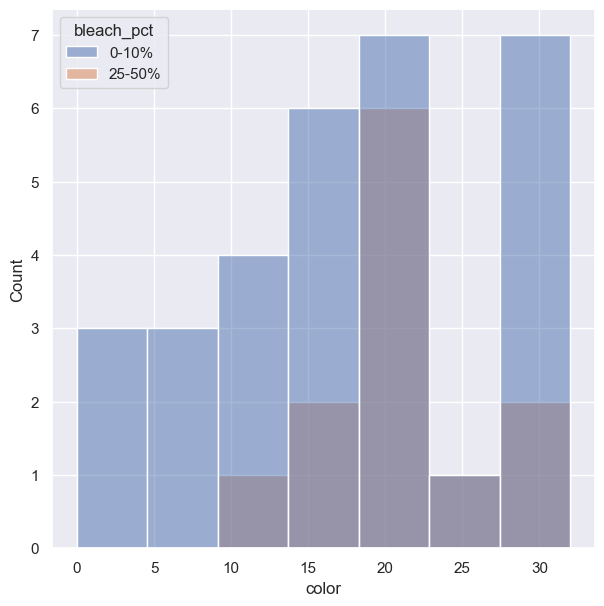

In [71]:
# plot the color
plt.figure(figsize=[7, 7])
hist = sns.histplot(data=gdf, x='color', hue='bleach_pct')


#  Ordinal Regression Model

In [72]:
# make dummy variables for location and shape
gdf_cat = pd.get_dummies(gdf, columns=['location', 'shape'], drop_first=True)

In [73]:
gdf.head()

,location,color,shape,bleach_pct,depth_ft
0,Hanauma Bay,19,crust,0-10%,5.0
1,Hanauma Bay,7,crust,0-10%,4.0
2,Hanauma Bay,19,branch,0-10%,4.0
3,Horseshoe Reef,22,mound,25-50%,45.0
4,Horseshoe Reef,15,mound,25-50%,45.0


In [74]:
# split X and y and remove categorical features
X = gdf.drop(columns=['bleach_pct', 'location', 'shape'])
y = gdf['bleach_pct']

In [75]:
# Ordinal Regression Probit Model
mod_prob = OrderedModel(y,
                        X,
                        distr='probit')

In [76]:
# fit the model using bfgs
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.557133
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             bleach_pct   Log-Likelihood:                -23.957
Model:                   OrderedModel   AIC:                             53.91
Method:            Maximum Likelihood   BIC:                             59.20
Date:                Sat, 01 Oct 2022                                         
Time:                        18:32:58                                         
No. Observations:                  43                                         
Df Residuals:                      40                                         
Df Model:                           3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
color            0.0257      0.028      0.912      0.362      -0.030       0.081
depth_ft         0.0134      0.012      1.101      0.271      -0.010       0.037
0-10%/25-50%     1.6278      0.695      2.341      0.019       0.265       2.990
================================================================================
"""

In [77]:
# Ordinal Regression Logit Model
mod_prob = OrderedModel(gdf['bleach_pct'],
                        gdf[['color', 'depth_ft']],
                        distr='logit')

In [78]:
# fit the model using bfgs
res_log = mod_prob.fit(method='bfgs')
res_log.summary()

Optimization terminated successfully.
         Current function value: 0.560202
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             bleach_pct   Log-Likelihood:                -24.089
Model:                   OrderedModel   AIC:                             54.18
Method:            Maximum Likelihood   BIC:                             59.46
Date:                Sat, 01 Oct 2022                                         
Time:                        18:32:58                                         
No. Observations:                  43                                         
Df Residuals:                      40                                         
Df Model:                           3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
color            0.0407      0.046      0.887      0.375      -0.049       0.131
depth_ft         0.0202      0.020      1.021      0.307      -0.019       0.059
0-10%/25-50%     2.5516      1.147      2.225      0.026       0.304       4.799
================================================================================
"""

In [79]:
# make predictions
predicted = res_log.model.predict(res_log.params, exog=X)
predicted

/Users/sree/anaconda3/lib/python3.9/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


array([[0.84265857, 0.15734143],
       [0.89900354, 0.10099646],
       [0.84531887, 0.15468113],
       [0.67874347, 0.32125653],
       [0.73741664, 0.26258336],
       [0.58454483, 0.41545517],
       [0.68754305, 0.31245695],
       [0.60414534, 0.39585466],
       [0.67874347, 0.32125653],
       [0.70473876, 0.29526124],
       [0.69620948, 0.30379052],
       [0.55495791, 0.44504209],
       [0.65186972, 0.34813028],
       [0.56497497, 0.43502503],
       [0.72161839, 0.27838161],
       [0.72161839, 0.27838161],
       [0.78891433, 0.21108567],
       [0.53479729, 0.46520271],
       [0.55495791, 0.44504209],
       [0.80850993, 0.19149007],
       [0.72161839, 0.27838161],
       [0.57493926, 0.42506074],
       [0.69646914, 0.30353086],
       [0.57493926, 0.42506074],
       [0.59467872, 0.40532128],
       [0.55495791, 0.44504209],
       [0.6878068 , 0.3121932 ],
       [0.65186972, 0.34813028],
       [0.69646914, 0.30353086],
       [0.72971124, 0.27028876],
       [0.

In [80]:
# calculate accuracy
pred_choice = predicted.argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(gdf['bleach_pct'].values.codes) == pred_choice).mean())

Fraction of correct choice predictions
0.7209302325581395


# Logistic Regression Model

In [81]:
# make dummy variable for bleach_pct
gdf['bleach_pct'] = gdf['bleach_pct'].cat.codes

In [82]:
# split X and y, while keeping categorical features
X = gdf.drop(columns=['bleach_pct', 'location', 'shape'])
y = gdf['bleach_pct']

In [83]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.6,
                                                    random_state=7,
                                                    stratify=y
                                                    )

In [84]:
# create ColumnTransformer that runs various scalers on color and depth_ft
column_transformer = ColumnTransformer(
    [('scaler', StandardScaler(), ['color', 'depth_ft']),
     ('robust', RobustScaler(), ['color', 'depth_ft']),
     ('minmax', MinMaxScaler(), ['color', 'depth_ft'])],
    remainder='passthrough'
)


In [85]:
# logistic regression implementation
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.634480
         Iterations 4
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.072 
Dependent Variable: bleach_pct       AIC:              58.5653
Date:               2022-10-01 18:32 BIC:              62.0877
No. Observations:   43               Log-Likelihood:   -27.283
Df Model:           1                LL-Null:          -25.459
Df Residuals:       41               LLR p-value:      1.0000 
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     4.0000                                    
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
color       -0.0334    0.0308  -1.0844  0.2782  -0.0937  0.0269
depth_ft    -0.0012    0.0139  -0.0858  0.9316  -0.0284  0.0261



In [86]:
# create pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('log', LogisticRegression(random_state=15))
])

# create grid of C values and various solvers
param_grid = {
    'log__C': [0.1, 1, 2, 10, 100, 1000, 10000, 100000],
    'log__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# grid search over the parameters
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, verbose=1)
grid.fit(X_train, y_train)

# print the results
print("Best params:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)
print("Score:", grid.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/sree/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Best params: {'log__C': 0.1, 'log__solver': 'newton-cg'}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('robust', RobustScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['color', 'depth_ft'])])),
                ('log',
                 LogisticRegression(C=0.1, random_state=15,
                                    solver='newton-cg'))])
Score: 0.7307692307692307


In [87]:
# use the best estimator for logistic regression, predict, and get classification report
logreg = LogisticRegression(C=grid.best_params_['log__C'],
                            solver=grid.best_params_['log__solver'])
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        19
           1       0.00      0.00      0.00         7

    accuracy                           0.73        26
   macro avg       0.37      0.50      0.42        26
weighted avg       0.53      0.73      0.62        26



Text(58.11555902777779, 0.5, 'Mean Test Score')

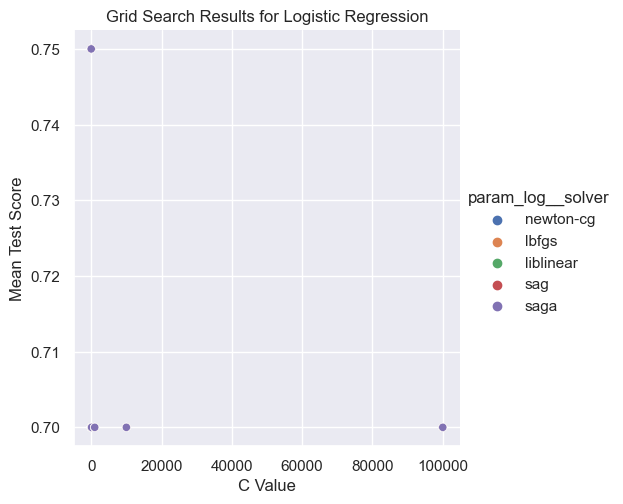

In [88]:
# put grid search results into a dataframe
grid_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

# plot grid search results dataframe using relplot
sns.relplot(x='param_log__C', y='mean_test_score',
            hue='param_log__solver', data=grid_df)
plt.title('Grid Search Results for Logistic Regression')
plt.xlabel('C Value')
plt.ylabel('Mean Test Score')

In [89]:
# logitstic regression with C value of 100000 and liblinear solver
logreg = LogisticRegression(C=100000, solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        19
           1       0.00      0.00      0.00         7

    accuracy                           0.73        26
   macro avg       0.37      0.50      0.42        26
weighted avg       0.53      0.73      0.62        26



# SVM

In [90]:
# create pipeline with preprocessor and SVM
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('svm', SVC(random_state=15))
])

# create grid of C values and various kernels
param_grid = {
    'svm__C': [10, 100, 1000],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# grid search over the parameters
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1)
grid.fit(X_train, y_train)

# print the scores for all the models
print("Best params:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)
print("Score:", grid.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('robust', RobustScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['color', 'depth_ft'])])),
                ('svm', SVC(C=10, random_state=15))])
Score: 0.9615384615384616


In [91]:
# use the best estimator for SVM, predict, and get confusion matrix
svm = SVC(C=grid.best_params_['svm__C'],
            kernel=grid.best_params_['svm__kernel'])
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



# Gradient Boosting Classifier

In [92]:
# create pipeline with preprocessor and gradient boosting classifier
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=15))
])

# create grid of learning rate, n_estimators, and max_depth
param_grid = {
    'gbc__learning_rate': [0.1, 0.5, 1],
    'gbc__n_estimators': [100, 200, 300],
    'gbc__max_depth': [1, 3, 5, 7]
}

# grid search over the parameters
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1)
grid.fit(X_train, y_train)

# print the results
print("Best params:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)
print("Score:", grid.best_estimator_.score(X_test, y_test))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 1, 'gbc__n_estimators': 100}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('robust', RobustScaler(),
                                                  ['color', 'depth_ft']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['color', 'depth_ft'])])),
                ('gbc',
                 GradientBoostingClassifier(max_depth=1, random_state=15))])
Score: 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



Text(65.06572222222223, 0.5, 'Mean Test Score')

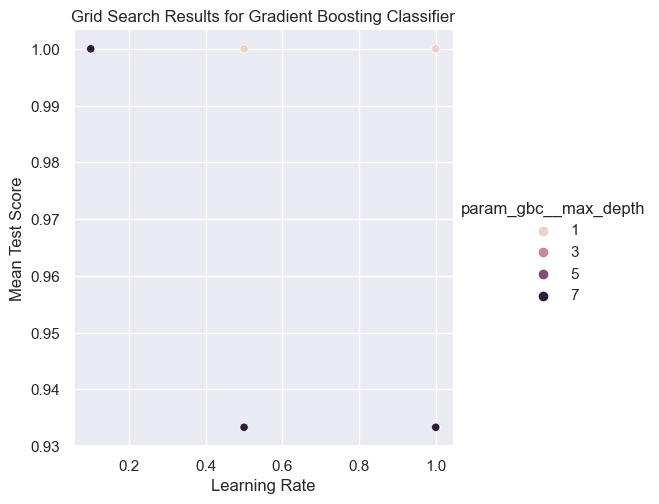

In [93]:
# run gradient boosting classifier with best parameters that dont overfit
gbc = GradientBoostingClassifier(learning_rate=grid.best_params_['gbc__learning_rate'],
                                    n_estimators=grid.best_params_['gbc__n_estimators'],
                                    max_depth=grid.best_params_['gbc__max_depth'])
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

# put grid search results into a dataframe
grid_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

# plot grid search results dataframe using relplot
sns.relplot(x='param_gbc__learning_rate', y='mean_test_score',
            hue='param_gbc__max_depth', data=grid_df)
plt.title('Grid Search Results for Gradient Boosting Classifier')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')


Overfitting: SVM and Gradient Boosting Classifier

Realistic models: Ordinal Regression or Logistic Regression with accuracy of 73%